In [12]:
import pandas as pd
import numpy as np
from utils import *
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 3)

In [3]:
DIR = "data/round-5/"

In [4]:
price = pd.read_csv(DIR+"price_history.csv", sep=";")

In [5]:
PB1 = price.loc[price["product"]=="PICNIC_BASKET1"].reset_index(drop=True)
PB2 = price.loc[price["product"]=="PICNIC_BASKET2"].reset_index(drop=True)
JAM = price.loc[price["product"]=="JAMS"].reset_index(drop=True)
CROSS = price.loc[price["product"]=="CROISSANTS"].reset_index(drop=True)
DJ = price.loc[price["product"]=="DJEMBES"].reset_index(drop=True)

<Axes: >

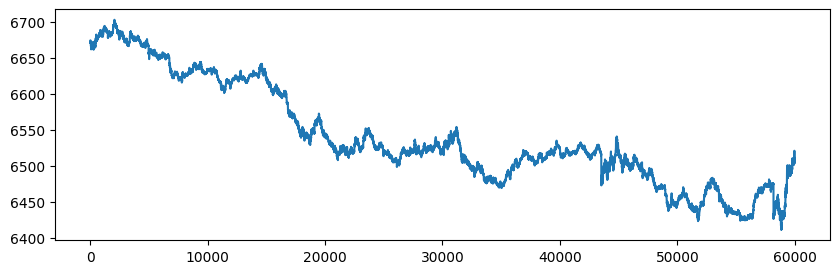

In [6]:
JAM["mid_price"].plot()

### Spread

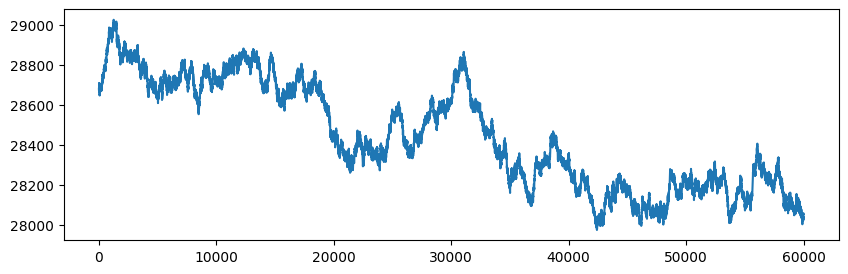

In [7]:
plt.plot(PB1["mid_price"].array-PB2["mid_price"].array)

Use spread between PB1 and PB2;
Find hedge ratio using linear regresion

In [8]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

data = pd.concat([PB1["mid_price"].loc[40000:], PB2["mid_price"].loc[40000:]], axis=1)
data.columns = ['A', 'B']

# Johansen test
jres = coint_johansen(data, det_order=0, k_ar_diff=1)

# Cointegration vector (normalised)
hedge_ratio = jres.evec[:, 0] / jres.evec[1, 0]  # Normalise on B

# Construct spread
spread = data['A'] * hedge_ratio[0] + data['B'] * hedge_ratio[1]

# Z-score of spread
zscore = (spread - spread.rolling(60).mean()) / spread.rolling(60).std()

print("Hedge ratio:", hedge_ratio)

Hedge ratio: [-2.15197823  1.        ]


In [9]:
arr = PB1["mid_price"].array - 2.16 * PB2["mid_price"].array
arr =  arr[:20000]
window = 50
threshold = 5.
stop = 0.5
sells, buys, exit = [], [], []
pos = 0

for i in range(window, len(arr)):
    window_data = arr[i-window:i]
    # mean = np.mean(window_data)
    mean = np.mean(arr[:30000])
    std = np.std(window_data)
    z = (arr[i] - mean) / std if std != 0 else 0

    if z > threshold:
        sells.append(i)
    if z < -threshold:
        buys.append(i)
    if z > -stop and z < stop:
        exit.append(i)

In [10]:
arr = PB1["mid_price"].array - 2.16 * PB2["mid_price"].array
np.mean(arr)

np.float64(-6656.668455333336)

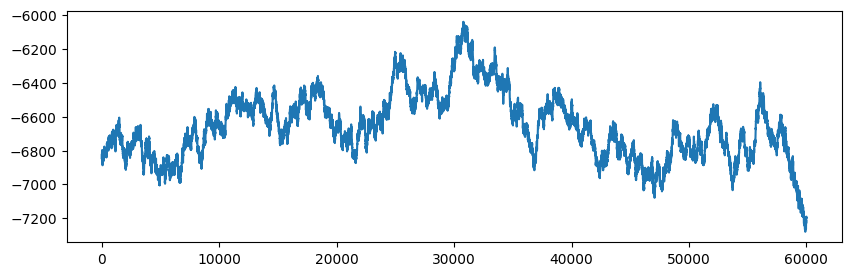

In [11]:
plt.plot(arr)

In [16]:
hist = get_tradehistory(DIR+"current.log")

In [17]:
basket_trades = get_mytrades(hist, "PICNIC_BASKET1")

In [18]:
buys = basket_trades.loc[basket_trades["buyer"]=="SUBMISSION"]["timestamp"].array // 100
sells = basket_trades.loc[basket_trades["seller"]=="SUBMISSION"]["timestamp"].array // 100

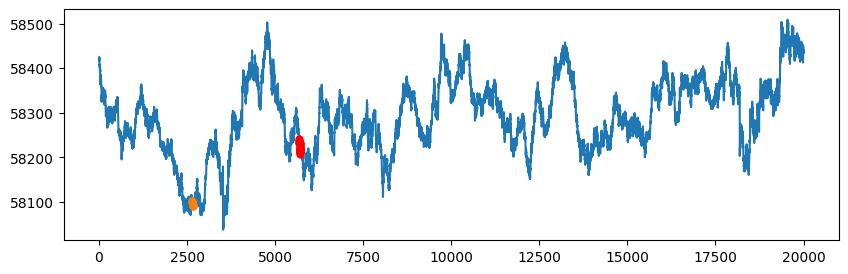

In [26]:
arr = PB1["mid_price"].loc[40000:].array
plt.plot(arr)
plt.plot(buys, arr[buys], lw=0, ms=10, marker='.')
plt.plot(sells, arr[sells], lw=0, ms=10, marker='.', color='r')

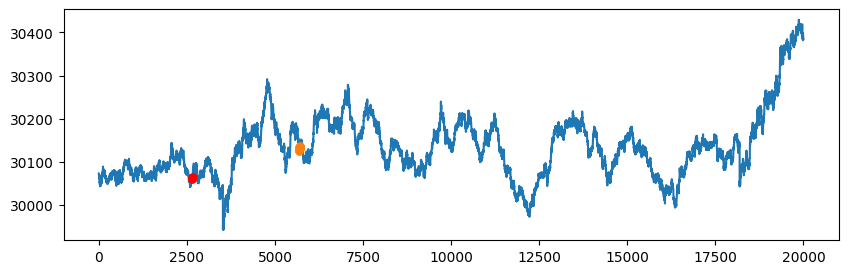

In [27]:
arr = PB2["mid_price"].loc[40000:].array
plt.plot(arr)
plt.plot(buys, arr[buys], lw=0, ms=10, marker='.', color='r')
plt.plot(sells, arr[sells], lw=0, ms=10, marker='.')

In [28]:
from statsmodels.tsa.stattools import adfuller

spread = PB1["mid_price"].array - 2.16 * PB2["mid_price"].array
result = adfuller(spread)

print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -2.9210272389673113
p-value: 0.04295688702154961


In [29]:
PB1 = price.loc[price["product"]=="PICNIC_BASKET1"].reset_index(drop=True)
PB2 = price.loc[price["product"]=="PICNIC_BASKET2"].reset_index(drop=True)
CROSS = price.loc[price["product"]=="CROISSANTS"].reset_index(drop=True)
JAM = price.loc[price["product"]=="JAMS"].reset_index(drop=True)
DJ = price.loc[price["product"]=="DJEMBES"].reset_index(drop=True)

In [30]:
basket_spread = PB1["mid_price"].array - PB2["mid_price"].array
synthetic_spread = 2 * CROSS["mid_price"].array + JAM["mid_price"].array + DJ["mid_price"].array

In [31]:
spread1 = find_spread(PB1, [CROSS, JAM, DJ], basket=1)
spread2 = find_spread(PB2, [CROSS, JAM], basket=2)

In [32]:
olivia_buys = [37899, 43436, 54526]
olivia_sells = [32016, 49710, 59037]

spread1 - spread2 = Basket1 - Basket2 - (6c+3j+d) + (4c+2j) = Basket1  - Basket2 - 2c - j - d

In [36]:
def kalman_filter(z, Q=1e-5, R=0.01):
    n = len(z)
    xhat = np.zeros(n)      # Estimated value
    P = np.zeros(n)         # Estimate uncertainty
    xhat[0] = z[0]          # Initial guess
    P[0] = 1.0

    for k in range(1, n):
        # Predict
        xhat_minus = xhat[k-1]
        P_minus = P[k-1] + Q

        # Update
        K = P_minus / (P_minus + R)
        xhat[k] = xhat_minus + K * (z[k] - xhat_minus)
        P[k] = (1 - K) * P_minus

    return xhat


In [37]:
np.corrcoef(PB1["mid_price"].array, PB2["mid_price"].array)

array([[1.       , 0.9118279],
       [0.9118279, 1.       ]])

In [38]:
np.corrcoef(CROSS["mid_price"].array, JAM["mid_price"].array)

array([[1.        , 0.64375213],
       [0.64375213, 1.        ]])

### Directly trade Baskets 1 and 2 without considering the contents

First static beta

/var/folders/tk/w4xllgbs0ds2ch4ngj5_n8280000gn/T/ipykernel_3214/1829007837.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


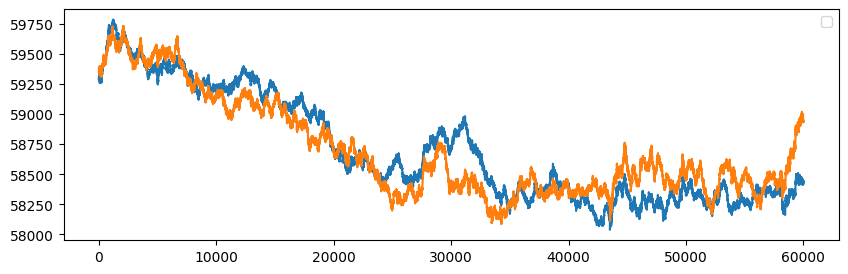

In [39]:
arr1 = PB1["mid_price"].array
arr2 =  PB2["mid_price"].array

covariance = np.cov(arr1, arr2)[0, 1]
variance_B = np.var(arr2)
beta = covariance / variance_B
intercept = np.mean(arr1) - beta * np.mean(arr2)

plt.plot(arr1)
plt.plot(beta * arr2 + intercept)

# plt.axvline(50000)
# plt.axvline(51000)
plt.legend()

dynamic beta

In [40]:
betas = []
intercepts = []
window_size = 100
for i in range(window_size, len(arr1)):
    # Define the current window
    window_A = arr1[i - window_size:i]
    window_B = arr2[i - window_size:i]

    # Calculate covariance and variance
    covariance = np.cov(window_A, window_B)[0, 1]
    variance_B = np.var(window_B)

    # Calculate beta (slope)
    beta = covariance / variance_B
    betas.append(beta)

    intercept = np.mean(window_A) - beta * np.mean(window_B)
    intercepts.append(intercept)

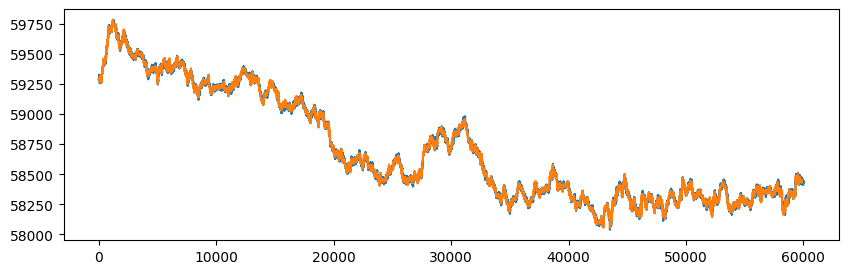

In [41]:
plt.plot(arr1)
plt.plot([beta * val + c for beta, val, c in zip(betas, arr2, intercepts)])

In [42]:
regressed = np.array([beta * val + c for beta, val, c in zip(betas, arr2, intercepts)])

In [43]:
spread = arr1[100:] - np.array([beta * val for beta, val in zip(betas, arr2)])

In [44]:
sells, buys, exit = [], [], []
w = 20
for i in range(w, len(spread)):
    window = spread[i - w:i]
    mean = np.mean(window)
    std = np.std(window)
    z = (spread[i] - mean) / std if std > 0 else 0

    if z > 3.5:
        sells.append(i)
    elif z < -3.5:
        buys.append(i)
    elif  z > -1 and z < 1:
        exit.append(i)

/var/folders/tk/w4xllgbs0ds2ch4ngj5_n8280000gn/T/ipykernel_3214/2528145991.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


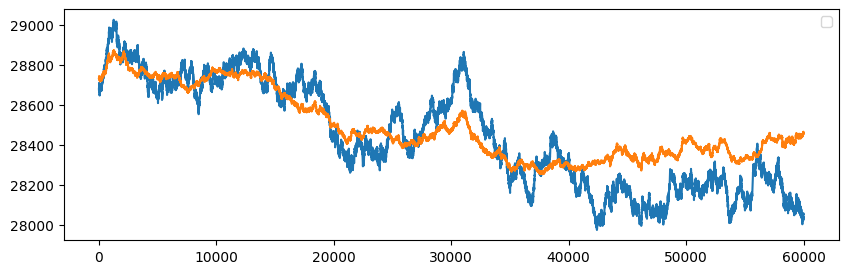

In [52]:
plt.plot(basket_spread)
plt.plot(synthetic_spread)
plt.legend()

### Counterparty Info

In [ ]:
tr1 = pd.read_csv("trades_round_5_day_2.csv",  sep=";")
tr1["day"] = [2] * len(tr1)
tr2 = pd.read_csv("trades_round_5_day_3.csv",  sep=";")
tr2["day"] = [3] * len(tr2)
tr3 = pd.read_csv("trades_round_5_day_4.csv",  sep=";")
tr3["day"] = [4] * len(tr3)

In [ ]:
trades = pd.concat((tr1, tr2, tr3)).reset_index(drop=True)

In [ ]:
trades.loc[trades["buyer"]=="Olivia"]

,timestamp,buyer,seller,symbol,currency,price,quantity,day
1991,115200,Olivia,Charlie,SQUID_INK,SEASHELLS,1772.0,15,2
14466,789900,Olivia,Caesar,CROISSANTS,SEASHELLS,4233.0,3,2
17902,980800,Olivia,Charlie,KELP,SEASHELLS,2042.0,15,2
24584,343600,Olivia,Caesar,CROISSANTS,SEASHELLS,4227.0,3,3
24589,343800,Olivia,Charlie,KELP,SEASHELLS,2032.0,15,3
27923,515300,Olivia,Charlie,SQUID_INK,SEASHELLS,1762.0,15,3
43938,452600,Olivia,Caesar,CROISSANTS,SEASHELLS,4264.0,3,4
49613,778300,Olivia,Charlie,KELP,SEASHELLS,2009.0,13,4
49614,778300,Olivia,Caesar,KELP,SEASHELLS,2009.0,2,4
52691,957500,Olivia,Charlie,SQUID_INK,SEASHELLS,1896.0,15,4


#### Croissants

In [ ]:
CROSS_trades = trades.loc[trades["symbol"]=='CROISSANTS']
CROSS = price.loc[price["product"]=="CROISSANTS"]
TIME = CROSS.loc[CROSS['day']==2]["timestamp"]
CROSS_trades_day2 = CROSS_trades.loc[CROSS_trades["day"]==2]
CROSS_trades_day3 = CROSS_trades.loc[CROSS_trades["day"]==3]
CROSS_trades_day4 = CROSS_trades.loc[CROSS_trades["day"]==4]

In [ ]:
CROSS_trades["buyer"].unique()

array(['Caesar', 'Paris', 'Olivia', 'Camilla'], dtype=object)

In [ ]:
CROSS_trades["seller"].unique()

array(['Paris', 'Caesar', 'Camilla', 'Olivia'], dtype=object)

### Good signals (CROISSANTS): Olivia buys & sells (best), Camilla buys - questionable

Strategy: check values up to current, if current val is less than or more than mean (otherwise window=50)

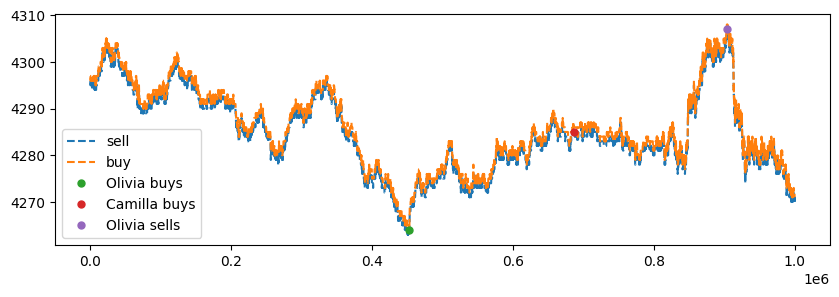

In [ ]:
df_trades = CROSS_trades_day4
day = 4

plt.plot(TIME, CROSS.loc[CROSS['day']==day]["bid_price_1"], label="sell", ls='dashed')
plt.plot(TIME, CROSS.loc[CROSS['day']==day]["ask_price_1"], label="buy",  ls='dashed')


plt.plot(df_trades.loc[df_trades["buyer"]=="Olivia"]["timestamp"],
         df_trades.loc[df_trades["buyer"]=="Olivia"]["price"],
         lw=0, ms=10, marker='.', label="Olivia buys")
plt.plot(df_trades.loc[df_trades["buyer"]=="Camilla"]["timestamp"],
         df_trades.loc[df_trades["buyer"]=="Camilla"]["price"],
         lw=0, ms=10, marker='.', label="Camilla buys")
plt.plot(df_trades.loc[df_trades["seller"]=="Olivia"]["timestamp"],
         df_trades.loc[df_trades["seller"]=="Olivia"]["price"],
         lw=0, ms=10, marker='.', label="Olivia sells")

plt.legend()


In [ ]:
CROSS_trades.loc[CROSS_trades["buyer"]=="Olivia"]

,timestamp,buyer,seller,symbol,currency,price,quantity,day
14466,789900,Olivia,Caesar,CROISSANTS,SEASHELLS,4233.0,3,2
24584,343600,Olivia,Caesar,CROISSANTS,SEASHELLS,4227.0,3,3
43938,452600,Olivia,Caesar,CROISSANTS,SEASHELLS,4264.0,3,4


In [ ]:
CROSS_trades.loc[CROSS_trades["seller"]=="Olivia"]

,timestamp,buyer,seller,symbol,currency,price,quantity,day
3515,201600,Caesar,Olivia,CROISSANTS,SEASHELLS,4278.0,3,2
35623,971000,Caesar,Olivia,CROISSANTS,SEASHELLS,4314.0,3,3
51796,903700,Caesar,Olivia,CROISSANTS,SEASHELLS,4307.0,3,4


In [ ]:
i = 7899
arr = CROSS.loc[CROSS["day"]==2]["mid_price"].array
print(i,  arr[i])
cut = arr[:i+1]
z = (cut[-1] - np.mean(cut))
print(z)

7899 4232.0
-25.05500000000029


In [ ]:
trades["symbol"].unique()

array(['CROISSANTS', 'RAINFOREST_RESIN', 'JAMS', 'KELP', 'SQUID_INK',
       'PICNIC_BASKET1', 'PICNIC_BASKET2', 'MAGNIFICENT_MACARONS',
       'DJEMBES', 'VOLCANIC_ROCK_VOUCHER_10000',
       'VOLCANIC_ROCK_VOUCHER_10250', 'VOLCANIC_ROCK_VOUCHER_10500',
       'VOLCANIC_ROCK_VOUCHER_9500', 'VOLCANIC_ROCK_VOUCHER_9750',
       'VOLCANIC_ROCK'], dtype=object)

### Questionable signal (JAMS): Camilla buys (only buys!)

In [ ]:
JAM_trades = trades.loc[trades["symbol"]=='JAMS']
JAM = price.loc[price["product"]=="JAMS"]
JAM_trades_day2 = JAM_trades.loc[JAM_trades["day"]==2]
JAM_trades_day3 = JAM_trades.loc[JAM_trades["day"]==3]
JAM_trades_day4 = JAM_trades.loc[JAM_trades["day"]==4]

In [ ]:
JAM_trades["buyer"].unique()

array(['Paris', 'Caesar', 'Camilla'], dtype=object)

In [ ]:
JAM_trades["seller"].unique()

array(['Caesar', 'Paris', 'Camilla'], dtype=object)

In [ ]:
TIME = np.arange(0, 1000000, 100)

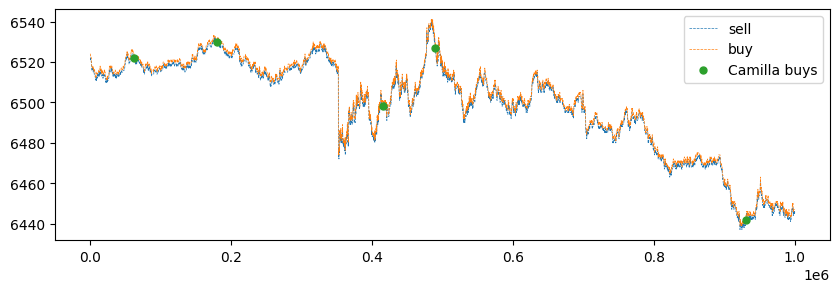

In [ ]:
df_trades = JAM_trades_day3
day = 3

plt.plot(TIME, JAM.loc[JAM['day']==day]["bid_price_1"], label="sell", lw=0.5, ls='dashed')
plt.plot(TIME, JAM.loc[JAM['day']==day]["ask_price_1"], label="buy", lw=0.5, ls='dashed')


plt.plot(df_trades.loc[df_trades["buyer"]=="Camilla"]["timestamp"],
         df_trades.loc[df_trades["buyer"]=="Camilla"]["price"],
         lw=0, ms=10, marker='.', label="Camilla buys")

plt.legend()


### SQUID; Olivia never lets down!

In [ ]:
SQUID_trades = trades.loc[trades["symbol"]=='SQUID_INK']
SQUID = price.loc[price["product"]=="SQUID_INK"]
SQUID_trades_day2 = SQUID_trades.loc[SQUID_trades["day"]==2]
SQUID_trades_day3 = SQUID_trades.loc[SQUID_trades["day"]==3]
SQUID_trades_day4 = SQUID_trades.loc[SQUID_trades["day"]==4]

In [ ]:
SQUID_trades["buyer"].unique()

In [ ]:
df_trades = SQUID_trades_day2
day = 2
person = "Olivia"

plt.plot(TIME, SQUID.loc[SQUID['day']==day]["bid_price_1"], label="sell", lw=0.5, ls='dashed')
plt.plot(TIME, SQUID.loc[SQUID['day']==day]["ask_price_1"], label="buy", lw=0.5, ls='dashed')


plt.plot(df_trades.loc[df_trades["buyer"]==person]["timestamp"],
         df_trades.loc[df_trades["buyer"]==person]["price"],
         lw=0, ms=10, marker='.', label="buys")
plt.plot(df_trades.loc[df_trades["seller"]==person]["timestamp"],
         df_trades.loc[df_trades["seller"]==person]["price"],
         lw=0, ms=10, marker='.', label="sells")

plt.legend()


In [ ]:
arr = SQUID.loc[SQUID['day']==4]["mid_price"].array
max = 1770.5

# for i in range(1152, len(arr)):
#   dev = (arr[i]-max)/arr[i]
#   if dev < 0.005:
#     print(max, arr[i])

In [ ]:
SQUID_trades.loc[SQUID_trades["seller"]=="Olivia"]

,timestamp,buyer,seller,symbol,currency,price,quantity,day
10737,580200,Paris,Olivia,SQUID_INK,SEASHELLS,1926.0,1,2
10738,580200,Charlie,Olivia,SQUID_INK,SEASHELLS,1924.0,14,2
34902,928000,Charlie,Olivia,SQUID_INK,SEASHELLS,1986.0,15,3
37002,51100,Charlie,Olivia,SQUID_INK,SEASHELLS,2047.0,15,4


In [ ]:
for i in range(508, 520):
    print(i, arr[i], (arr[i] - np.mean(arr[:i])) / arr[i])


508 2043.0 0.027605786611475325
509 2045.5 0.028740072966726034
510 2048.5 0.03010619917969632
511 2048.0 0.029810478076076286
512 2047.0 0.029278269265999024
513 2045.5 0.02850930798029047
514 2043.0 0.02726497045048955
515 2042.5 0.026973892170027665
516 2043.5 0.027397799413151593
517 2043.0 0.027106759790235236
518 2041.0 0.026101029285742615
519 2041.5 0.026289275944196482


In [ ]:
i = 5802
arr = SQUID.loc[SQUID["day"]==2]["mid_price"].array
print(i,  arr[i])
cut = arr[:i+1]
z = (cut[-1] - np.mean(cut))
print(z)

5802 1926.0
100.22781320006902


### KELP

In [ ]:
KELP_trades = trades.loc[trades["symbol"]=='KELP']
KELP = price.loc[price["product"]=="KELP"]
KELP_trades_day2 = KELP_trades.loc[KELP_trades["day"]==2]
KELP_trades_day3 = KELP_trades.loc[KELP_trades["day"]==3]
KELP_trades_day4 = KELP_trades.loc[KELP_trades["day"]==4]

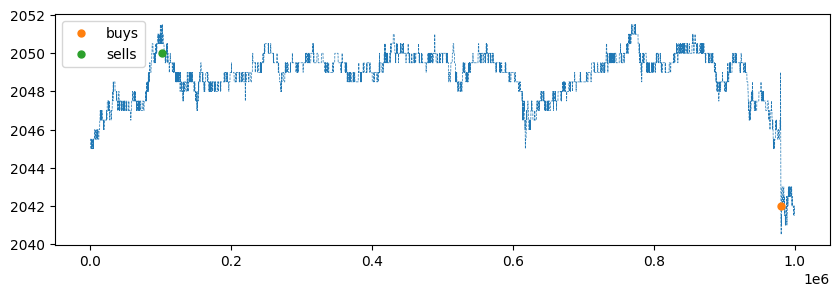

In [ ]:
df_trades = KELP_trades_day2
day = 2
person = "Olivia"

plt.plot(TIME, KELP.loc[KELP['day']==day]["mid_price"], lw=0.5, ls='dashed')


plt.plot(df_trades.loc[df_trades["buyer"]==person]["timestamp"],
         df_trades.loc[df_trades["buyer"]==person]["price"],
         lw=0, ms=10, marker='.', label="buys")
plt.plot(df_trades.loc[df_trades["seller"]==person]["timestamp"],
         df_trades.loc[df_trades["seller"]==person]["price"],
         lw=0, ms=10, marker='.', label="sells")

plt.legend()


#### Macaron

In [ ]:
OBS = pd.read_csv("OBS.csv", sep=";")

In [ ]:
MAC = pd.read_csv("MACARONS.csv", sep=";")

In [ ]:
OBS.columns

Index(['timestamp', 'bidPrice', 'askPrice', 'transportFees', 'exportTariff',
       'importTariff', 'sugarPrice', 'sunlightIndex', 'day'],
      dtype='object')

<Axes: >

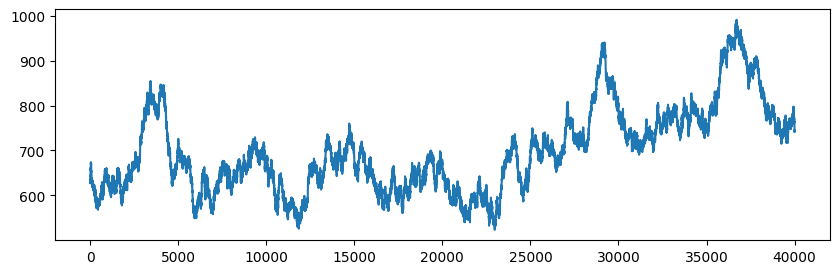

In [ ]:
MAC["mid_price"].plot()

<Axes: >

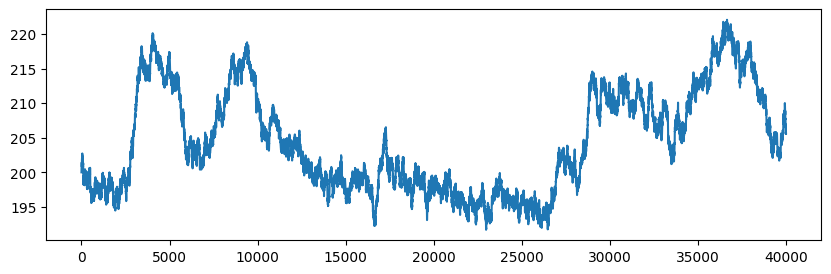

In [ ]:
OBS["sugarPrice"].plot()

In [ ]:
np.corrcoef(OBS["sunlightIndex"].array, MAC["mid_price"].array)

array([[ 1.        , -0.60485141],
       [-0.60485141,  1.        ]])

In [ ]:
mp = MAC["mid_price"].array
sp = OBS["sugarPrice"].array
sun = OBS["sunlightIndex"].array

In [ ]:
arr = sun
prev_return = None
change = []
magnitude = []
crit = 35

for t in range(1, len(arr)):
    if arr[t] > crit:
      continue
    ret = arr[t] - arr[t - 1]
    if ret == 0:
        continue

    if prev_return is not None and ret * prev_return < 0:
        print(ret, prev_return)
        # print(arr[t] - np.mean(arr[t-100:t]))
        change.append(t)

    prev_return = ret

0.03999999999999915 -0.019999999999999574
-0.00999999999999801 0.03999999999999915
0.010000000000001563 -0.010000000000001563


In [ ]:
change

[4001, 36429, 37002]

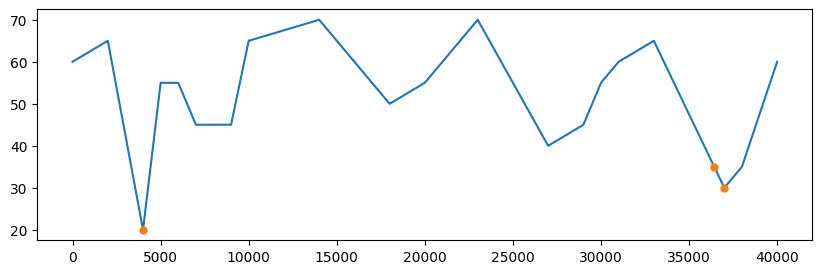

In [ ]:
plt.plot(arr)
plt.plot(change, sun[change], lw=0, marker='.', ms=10)

In [ ]:
sun[37000-2:37005]

<NumpyExtensionArray>
[np.float64(30.02), np.float64(30.01),  np.float64(30.0),  np.float64(30.0),
 np.float64(30.01), np.float64(30.02), np.float64(30.02)]
Length: 7, dtype: float64

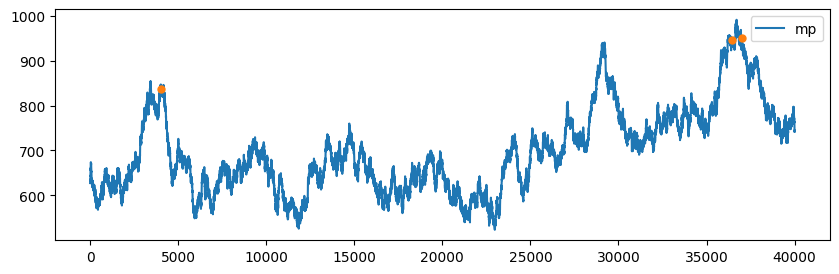

In [ ]:
plt.plot(mp, label="mp")
plt.plot(change, mp[change], lw=0, ms=10, marker='.')
# plt.plot(neg, mp[neg], lw=0, ms=10, marker='.')
plt.legend()

In [ ]:
hist = get_tradehistory("current.log")
trades_mac =  get_mytrades(hist, "MAGNIFICENT_MACARONS")

In [ ]:
sell_times = trades_mac.loc[trades_mac["seller"]=='SUBMISSION']['timestamp'].array // 100
buy_times = trades_mac.loc[trades_mac["buyer"]=='SUBMISSION']['timestamp'].array // 100

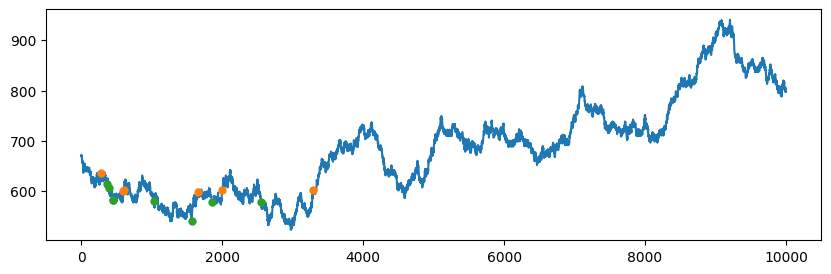

In [ ]:
plt.plot(MAC.loc[MAC["day"]==3]["mid_price"].array)
plt.plot(sell_times, MAC.loc[MAC["day"]==3]["mid_price"].array[sell_times], lw=0, marker='.', ms=10)
plt.plot(buy_times, MAC.loc[MAC["day"]==3]["mid_price"].array[buy_times], lw=0, marker='.', ms=10, label="byt")
# plt.xlim(0,1000)
# plt.ylim((680, 800))

###  Scrape the final bits

In [ ]:
hist = get_tradehistory("current.log")
trades1 =  get_mytrades(hist, "PICNIC_BASKET1")
trades2 =  get_mytrades(hist, "PICNIC_BASKET2")

In [ ]:
buytm = trades2.loc[trades2["buyer"]=="SUBMISSION"]["timestamp"].array // 100
selltm = trades2.loc[trades2["seller"]=="SUBMISSION"]["timestamp"].array // 100

In [ ]:
arr = PB2.loc[PB2["day"]==4]
arr = arr["mid_price"].array

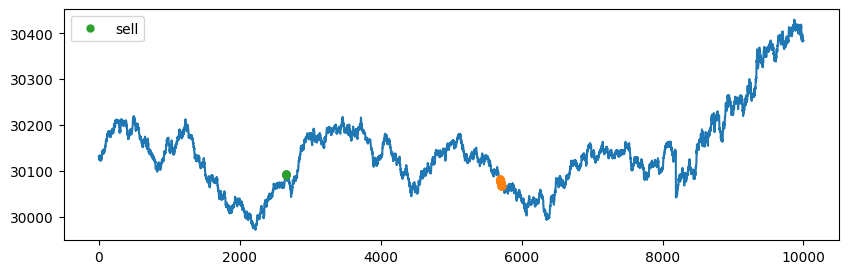

In [ ]:
plt.plot(arr)
plt.plot(buytm, arr[buytm], lw=0, ms=10, marker='.')
plt.plot(selltm, arr[selltm], lw=0, ms=10, marker='.', label="sell")
plt.legend()